<a href="https://colab.research.google.com/github/marcinwolter/DeepLearning_2020_private/blob/main/CNN_augmentation_kfold_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modified version of:
https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-/blob/master/CNN%20with%20Image%20Augmentation%20(CIFAR10).ipynb 



### CNN with Image Augmentation (CIFAR10)
images of 10 categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck. In RGB, 32x32 pixels. The state of the art accuracy is about 99 percent.


In [1]:
import tensorflow as tf
import numpy as np                                
import matplotlib.pyplot as plt
import keras as k
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
import h5py
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import EarlyStopping

from sklearn.model_selection import KFold

In [2]:
#load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_rows, img_cols , channels= 32,32,3

# select three classes only and limited number of events

N_TRAIN_EXAMPLES = 1500
#N_TEST_EXAMPLES = 100
N_CLASSES = 3

print("Original data")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

indices = np.where(y_train < N_CLASSES)
indices = indices[0]
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]


indices = np.where(y_test < N_CLASSES)
indices = indices[0]
np.random.shuffle(indices)
x_test = x_test[indices]
y_test = y_test[indices]

x_train = x_train[:N_TRAIN_EXAMPLES]
y_train = y_train[:N_TRAIN_EXAMPLES]

print(" ")
print("Truncated data")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



170500096/170498071 [==============================] - 2s 0us/step
Original data
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
 
Truncated data
(1500, 32, 32, 3)
(1500, 1)
(3000, 32, 32, 3)
(3000, 1)


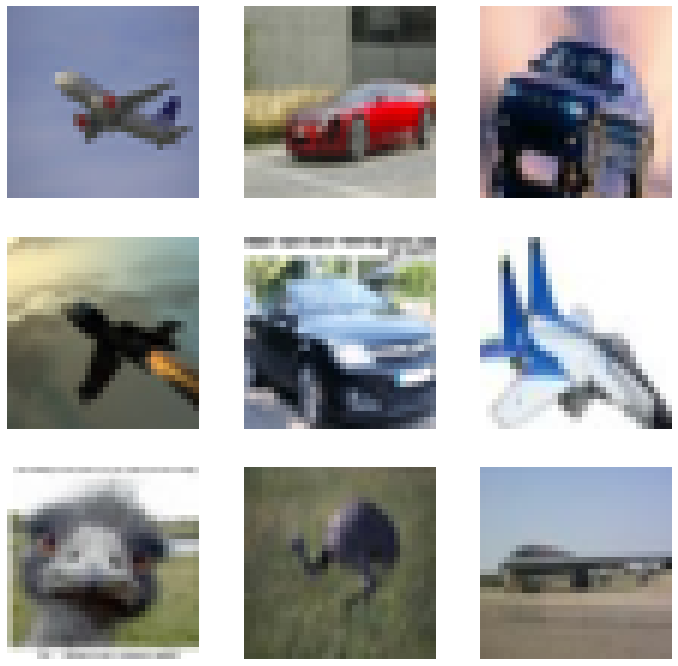

In [3]:
# save x_test images
xx_test = x_test
yy_test = y_test




fig = plt.figure(figsize=(12, 12))
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.axis('off')
    #print(x_train[i].shape)
    plt.imshow(x_train[i])
plt.show()

In [4]:
# set up image augmentation
datagen = ImageDataGenerator( 
    rotation_range=30,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25
    )
datagen.fit(x_train)

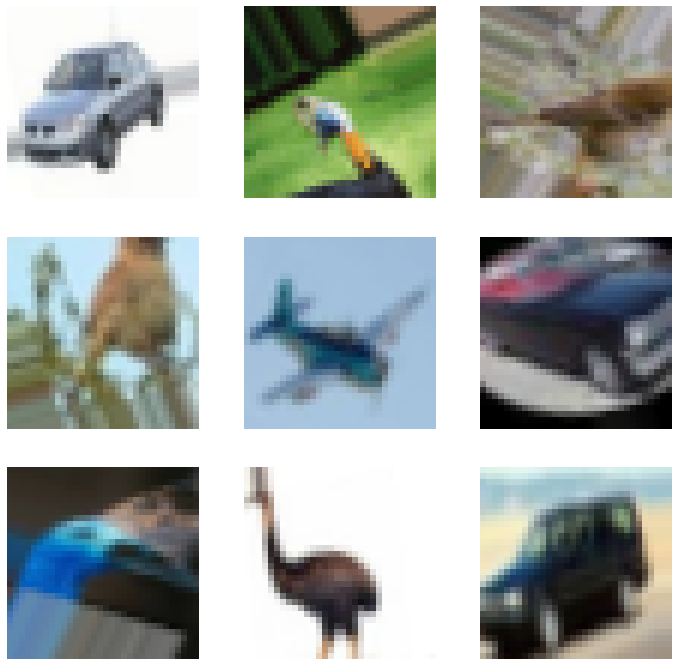

In [5]:
# see example augmentation images
fig = plt.figure(figsize=(12, 12))
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
         plt.subplot(330 + 1 + i)
         plt.imshow(X_batch[i].astype(np.uint8))
         plt.axis('off')
    plt.show()
    break

   

Augmentation of a single image

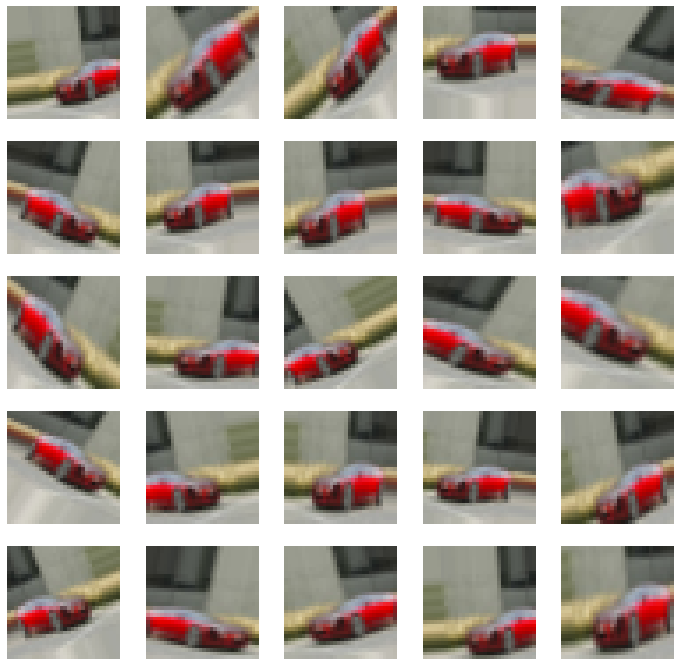

In [6]:
# see example augmentation images
fig = plt.figure(figsize=(12, 12))

for i in range(0, 25):
    for X_batch, y_batch in datagen.flow(x_train[1:3], y_train[1:3], batch_size=1, shuffle=False):
         plt.subplot(5,5,i+1)
         plt.imshow(X_batch[0].astype(np.uint8))
         plt.axis('off')
         break

plt.show()
    


In [7]:
#reshape into images
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (1500, 32, 32, 3)
1500 train samples
3000 test samples


In [8]:
#convert integers to float; normalise and center the mean
x_train=x_train.astype("float32")  
x_test=x_test.astype("float32")
mean=np.mean(x_train)
std=np.std(x_train)
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std

In [9]:
 # labels
y_train = k.utils.to_categorical(y_train, N_CLASSES)
y_test = k.utils.to_categorical(y_test, N_CLASSES)

In [10]:
# build and compile the model  (roughly following the VGG paper)

#reg=l2(1e-4)   # L2 or "ridge" regularisation
reg=None
num_filters=32
ac='relu'
adm=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt=adm
drop_dense=0.5
drop_conv=0

model = Sequential()

model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(img_rows, img_cols, channels),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
model.add(Dropout(drop_conv))

model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
model.add(Dropout(drop_conv))

model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
model.add(Dropout(drop_conv))

model.add(Flatten())
model.add(Dense(512, activation=ac,kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(N_CLASSES, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

# **TRAINING WITHOUT AUGMENTATION**

In [12]:
# training without augmentation

es = EarlyStopping(
    monitor="val_accuracy",
    patience=60,
    verbose=1
  )

history=model.fit(x_train, y_train, batch_size=128, epochs=150, validation_data=(x_test, y_test))

Epoch 1/150
12/12 [==============================] - 9s 89ms/step - loss: 1.4392 - accuracy: 0.5633 - val_loss: 1.0327 - val_accuracy: 0.5143
Epoch 2/150
12/12 [==============================] - 0s 28ms/step - loss: 0.6013 - accuracy: 0.7844 - val_loss: 1.1114 - val_accuracy: 0.5057
Epoch 3/150
12/12 [==============================] - 0s 27ms/step - loss: 0.3606 - accuracy: 0.8779 - val_loss: 1.1656 - val_accuracy: 0.3670
Epoch 4/150
12/12 [==============================] - 0s 27ms/step - loss: 0.2016 - accuracy: 0.9345 - val_loss: 1.2888 - val_accuracy: 0.4000
Epoch 5/150
12/12 [==============================] - 0s 38ms/step - loss: 0.1513 - accuracy: 0.9452 - val_loss: 1.3821 - val_accuracy: 0.4870
Epoch 6/150
12/12 [==============================] - 0s 26ms/step - loss: 0.0935 - accuracy: 0.9709 - val_loss: 1.4173 - val_accuracy: 0.4663
Epoch 7/150
12/12 [==============================] - 0s 27ms/step - loss: 0.0407 - accuracy: 0.9902 - val_loss: 1.7120 - val_accuracy: 0.4497
Epoch 

In [13]:
#training accuracy 
train_acc=model.evaluate(x_train,y_train,batch_size=128)
train_acc

12/12 [==============================] - 0s 6ms/step - loss: 3.0118e-06 - accuracy: 1.0000


[3.0117653295747004e-06, 1.0]

In [14]:
# plotting helper function
def plothist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

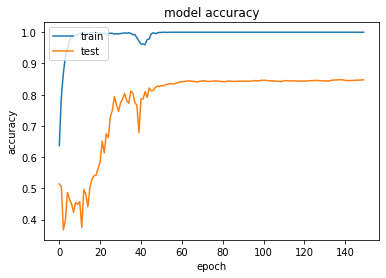

In [15]:
plothist(history)

In [16]:
#model.save('cifar10_01.h5')                  
#model=load_model('cifar10_01.h5')

In [17]:
# build again, same model as model1

#reg=l2(1e-4)   # L2 or "ridge" regularisation
reg2=None
num_filters2=32
ac2='relu'
adm2=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt2=adm2
drop_dense2=0.5
drop_conv2=0

model2 = Sequential()

model2.add(Conv2D(num_filters2, (3, 3), activation=ac2, kernel_regularizer=reg2, input_shape=(img_rows, img_cols, channels),padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(Conv2D(num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
model2.add(Dropout(drop_conv2))

model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
model2.add(Dropout(drop_conv2))

model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
model2.add(Dropout(drop_conv2))

model2.add(Flatten())
model2.add(Dense(512, activation=ac2,kernel_regularizer=reg2))
model2.add(BatchNormalization())
model2.add(Dropout(drop_dense2))
model2.add(Dense(N_CLASSES, activation='softmax'))

model2.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt2)

In [18]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)       

# **TRAINING WITH DATA AUGMENTATION**

In [19]:
# train with image augmentation

es = EarlyStopping(
    monitor="val_accuracy",
    patience=60,
    verbose=0
  )

history2=model2.fit(datagen.flow(x_train, y_train, batch_size=128),
                     batch_size=128, epochs=150, validation_data=(x_test, y_test))

Epoch 1/150
12/12 [==============================] - 2s 100ms/step - loss: 1.6504 - accuracy: 0.5403 - val_loss: 1.2117 - val_accuracy: 0.3523
Epoch 2/150
12/12 [==============================] - 1s 79ms/step - loss: 1.1702 - accuracy: 0.6511 - val_loss: 1.5132 - val_accuracy: 0.3893
Epoch 3/150
12/12 [==============================] - 1s 79ms/step - loss: 0.8911 - accuracy: 0.6984 - val_loss: 1.6977 - val_accuracy: 0.3687
Epoch 4/150
12/12 [==============================] - 1s 83ms/step - loss: 0.8116 - accuracy: 0.6964 - val_loss: 1.9087 - val_accuracy: 0.3563
Epoch 5/150
12/12 [==============================] - 1s 78ms/step - loss: 0.7651 - accuracy: 0.7046 - val_loss: 2.3971 - val_accuracy: 0.3367
Epoch 6/150
12/12 [==============================] - 1s 79ms/step - loss: 0.7106 - accuracy: 0.7330 - val_loss: 2.4565 - val_accuracy: 0.3927
Epoch 7/150
12/12 [==============================] - 1s 77ms/step - loss: 0.6804 - accuracy: 0.7433 - val_loss: 3.0022 - val_accuracy: 0.3333
Epoch

In [20]:
#model2.save('cifar10_02.h5')         # about 90% accuracy

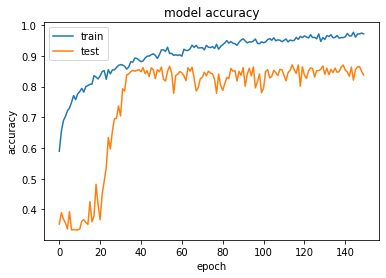

In [21]:
plothist(history2)  # 128 batch, 0.001 lr, 

In [22]:
print(x_test.shape,y_test.shape)
model2_test_acc=model2.evaluate(x_test,y_test,batch_size=128)
model2_test_acc

(3000, 32, 32, 3) (3000, 3)
24/24 [==============================] - 0s 7ms/step - loss: 0.7064 - accuracy: 0.8377


[0.7063698768615723, 0.8376666903495789]

In [23]:
model2_train_acc=model2.evaluate(x_train,y_train,batch_size=128)
model2_train_acc

12/12 [==============================] - 0s 7ms/step - loss: 0.1403 - accuracy: 0.9560


[0.1402612179517746, 0.9559999704360962]

# **Plot images**

In [24]:
def plot_images(model2):
# Names of predicted classes (randomly chosen images)

  import random


  class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

  y_pred = model2.predict_classes(x_test)
  y_pred_prob = model2.predict(x_test)

  grid_w = 10
  grid_h = 10

  fig = plt.figure(figsize=(20, 40))
  for i in range(0,grid_w*grid_h):
    i_pos = 2*(int(i/grid_w))*grid_w+ i%grid_w + 1
    #print(i_pos)
    plt.subplot(2*grid_h, grid_w, i_pos)
    i_img = random.randint(0,len(xx_test))
    plt.imshow(xx_test[i_img])
    #plt.bar([0,1,2,3,4,5,6,7,8,9],y_test[i_img])
    plt.axis('off')
    if yy_test[i_img] == y_pred[i_img]:
      plt.text(0, -2, class_names[int(yy_test[i_img])], color='green', fontsize=12)
    else:
      plt.text(0, -2, class_names[int(yy_test[i_img])]+" "+class_names[y_pred[i_img]], color='red', fontsize=12)  
    plt.subplot(2*grid_h, grid_w, i_pos + grid_w)
    xbar = np.linspace(1, N_CLASSES, num=N_CLASSES)
    plt.bar(xbar,y_pred_prob[i_img])
    plt.axis('off')

  plt.show()


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


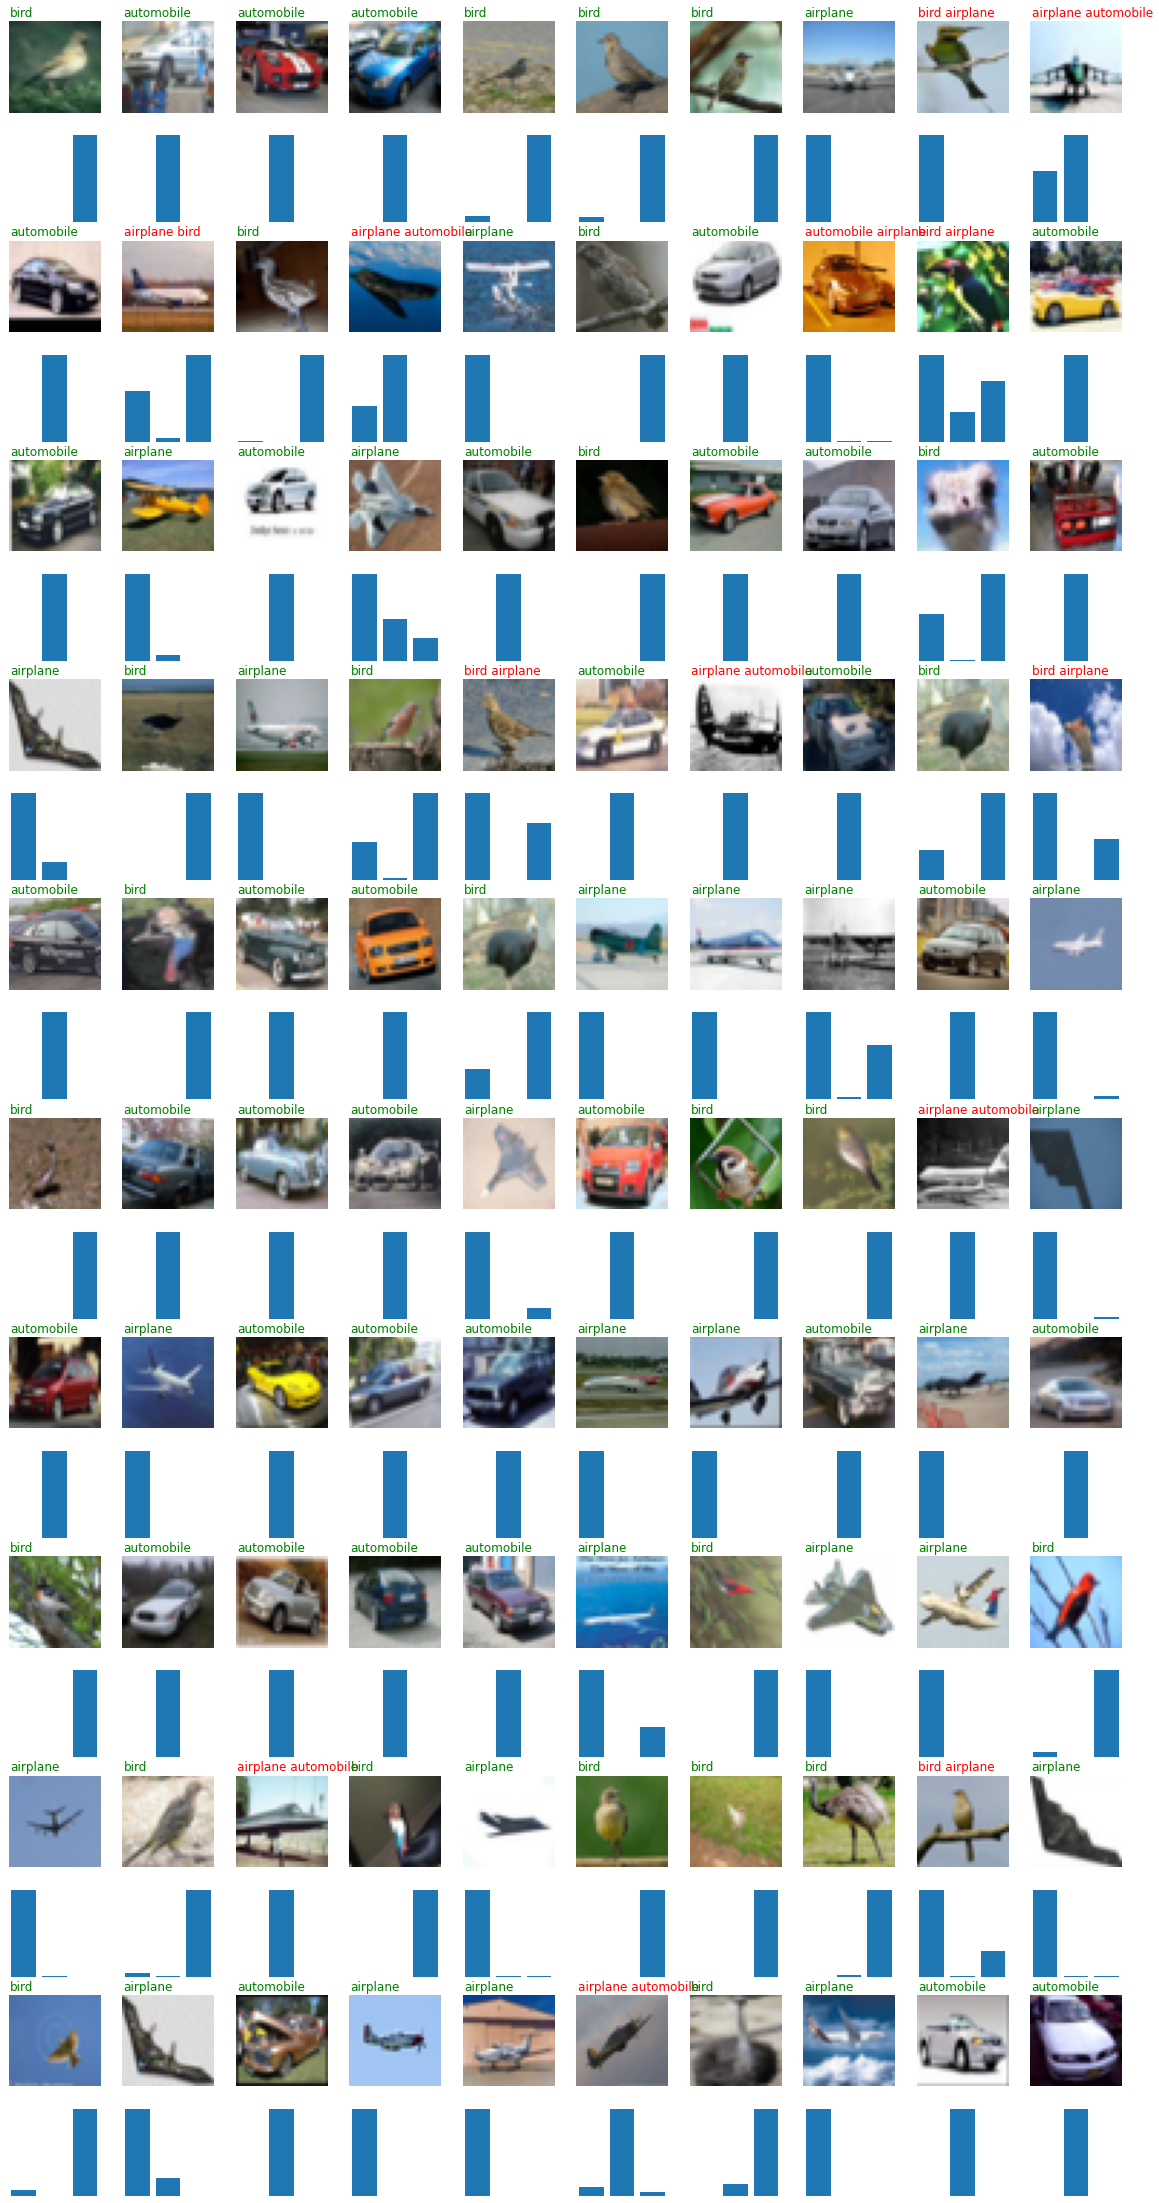

In [25]:
plot_images(model2)

In [26]:
# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model2.predict(x_test, verbose=2)

y_pred = np.argmax(Y_pred, axis=1)

#confusion matrix
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)



94/94 - 0s
[[742 183  75]
 [  9 981  10]
 [119  91 790]]


# **Optuna & K-FOLDING optimization**





In [27]:
def create_model(numfilters2):

  #reg=l2(1e-4)   # L2 or "ridge" regularisation
  reg2=None
  #num_filters2=32
  ac2='relu'
  adm2=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
  opt2=adm2
  drop_dense2=0.5
  drop_conv2=0

  model2 = Sequential()

  model2.add(Conv2D(num_filters2, (3, 3), activation=ac2, kernel_regularizer=reg2, input_shape=(img_rows, img_cols, channels),padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
  model2.add(Dropout(drop_conv2))

  model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
  model2.add(Dropout(drop_conv2))

  model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
  model2.add(Dropout(drop_conv2))

  model2.add(Flatten())
  model2.add(Dense(512, activation=ac2,kernel_regularizer=reg2))
  model2.add(BatchNormalization())
  model2.add(Dropout(drop_dense2))
  model2.add(Dense(N_CLASSES, activation='softmax'))

  model2.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt2)

  return model2

In [28]:
def fit_model(model2, datagen, x_train, y_train, x_val, y_val):

  # train with image augmentation

  es = EarlyStopping(
    monitor="val_accuracy",
    patience=60,
    verbose=1
  )

  history2=model2.fit(datagen.flow(x_train, y_train, batch_size=128),
                     batch_size=128, epochs=150, validation_data=(x_val, y_val), verbose=0)
  return history2, model2

In [29]:
# OPTUNA

! pip install optuna

import optuna

     |████████████████████████████████| 266kB 12.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163kB 33.7MB/s 
     |████████████████████████████████| 81kB 12.7MB/s 
     |████████████████████████████████| 81kB 10.6MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 112kB 53.3MB/s 
     |████████████████████████████████| 133kB 52.3MB/s 
  Created wheel for optuna: filename=optuna-2.3.0-cp36-none-any.whl size=359761 sha256=ff2d1db9b06adb29d2257a2071ac3099e56dd64991f4008e3b9ec328df7f20e7
  Stored in directory: /root/.cache/pip/wheels/fa/91/19/64b0ec6b964f89c0695a9dc6db6f851d0b54c5381a5c9cadfb
Successfully built optuna
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 sha256=7a6bb05f16c856f41553bcadbe969f48c40d5b19c1560487e5401bfa34ae0dcf
  Stored in directory: /root/.cache/pip/

In [30]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5, datagen=datagen, num_filters=num_filters):

  scores=[]
  histories=[]
  models=[]

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    # create model
    model = create_model(num_filters)
    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    # fit model
    history, model = fit_model(model, datagen, trainX, trainY, testX, testY)
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('Folding, acc =  %.3f' % (acc * 100.0))
		# stores scores
    scores.append(acc)
    histories.append(history)
    models.append(model)
  return scores, histories, models

# **Define objective**

In [31]:

def objective(trial):
    
    

    num_filters = int(trial.suggest_discrete_uniform("num_filters", 8,128,1))
    shift_range = trial.suggest_uniform('shift_range', .0,.4)
    rotation_range = trial.suggest_uniform('rotation_range', 0.,40.)

    # set up image augmentation
    datagen = ImageDataGenerator( 
      rotation_range=rotation_range,
      horizontal_flip=True,
      width_shift_range=shift_range,
      height_shift_range=shift_range,
      zoom_range=shift_range
    )
    datagen.fit(x_train)


    #create and evaluate model
    scores, histories, models = evaluate_model(x_train, y_train, n_folds=5, datagen=datagen, num_filters=num_filters)

    return np.mean(scores)

In [32]:

study = optuna.create_study(direction='maximize',  sampler=optuna.samplers.TPESampler() )

study.optimize(objective, n_trials=50)

study.best_params

[I 2020-12-25 10:53:33,270] A new study created in memory with name: no-name-ed1f9d41-6036-4f0a-b23a-ecccc1ecc119


Folding, acc =  79.667
Folding, acc =  84.667
Folding, acc =  83.333
Folding, acc =  87.000


[I 2020-12-25 11:01:39,805] Trial 0 finished with value: 0.8220000028610229 and parameters: {'num_filters': 109.0, 'shift_range': 0.295700431436415, 'rotation_range': 33.515975693511}. Best is trial 0 with value: 0.8220000028610229.


Folding, acc =  76.333
Folding, acc =  84.333
Folding, acc =  82.667
Folding, acc =  80.667
Folding, acc =  82.333


[I 2020-12-25 11:09:38,460] Trial 1 finished with value: 0.8293333292007447 and parameters: {'num_filters': 18.0, 'shift_range': 0.35527901234342596, 'rotation_range': 15.320283326008667}. Best is trial 1 with value: 0.8293333292007447.


Folding, acc =  84.667
Folding, acc =  82.667
Folding, acc =  80.667
Folding, acc =  83.000
Folding, acc =  81.333


[I 2020-12-25 11:17:18,202] Trial 2 finished with value: 0.8173333287239075 and parameters: {'num_filters': 47.0, 'shift_range': 0.3523021402800824, 'rotation_range': 11.234380220185653}. Best is trial 1 with value: 0.8293333292007447.


Folding, acc =  81.000
Folding, acc =  83.333
Folding, acc =  83.333
Folding, acc =  83.667
Folding, acc =  86.000


[I 2020-12-25 11:24:51,905] Trial 3 finished with value: 0.8153333187103271 and parameters: {'num_filters': 10.0, 'shift_range': 0.3857298652835019, 'rotation_range': 10.56093752999419}. Best is trial 1 with value: 0.8293333292007447.


Folding, acc =  71.333
Folding, acc =  82.667
Folding, acc =  83.333
Folding, acc =  83.000
Folding, acc =  87.333


[I 2020-12-25 11:32:13,481] Trial 4 finished with value: 0.8273333191871644 and parameters: {'num_filters': 119.0, 'shift_range': 0.15333130061405684, 'rotation_range': 35.94120236694738}. Best is trial 1 with value: 0.8293333292007447.


Folding, acc =  77.333
Folding, acc =  85.333
Folding, acc =  85.667
Folding, acc =  81.333
Folding, acc =  84.000


[I 2020-12-25 11:39:33,775] Trial 5 finished with value: 0.8353333353996277 and parameters: {'num_filters': 31.0, 'shift_range': 0.10968800104753439, 'rotation_range': 25.632793366404112}. Best is trial 5 with value: 0.8353333353996277.


Folding, acc =  81.333
Folding, acc =  79.000
Folding, acc =  80.333
Folding, acc =  75.333
Folding, acc =  82.000


[I 2020-12-25 11:46:59,287] Trial 6 finished with value: 0.7920000076293945 and parameters: {'num_filters': 99.0, 'shift_range': 0.3595554117011719, 'rotation_range': 17.676789122604024}. Best is trial 5 with value: 0.8353333353996277.


Folding, acc =  79.333
Folding, acc =  82.667
Folding, acc =  82.667
Folding, acc =  73.333
Folding, acc =  81.667


[I 2020-12-25 11:54:25,018] Trial 7 finished with value: 0.8 and parameters: {'num_filters': 111.0, 'shift_range': 0.3135524096367493, 'rotation_range': 38.89915090254882}. Best is trial 5 with value: 0.8353333353996277.


Folding, acc =  79.667
Folding, acc =  84.333
Folding, acc =  82.667
Folding, acc =  77.667
Folding, acc =  88.333


[I 2020-12-25 12:01:46,983] Trial 8 finished with value: 0.8279999852180481 and parameters: {'num_filters': 100.0, 'shift_range': 0.1650986175218062, 'rotation_range': 31.802525003587565}. Best is trial 5 with value: 0.8353333353996277.


Folding, acc =  81.000
Folding, acc =  87.667
Folding, acc =  84.667
Folding, acc =  84.000
Folding, acc =  77.000


[I 2020-12-25 12:09:12,278] Trial 9 finished with value: 0.8353333234786987 and parameters: {'num_filters': 16.0, 'shift_range': 0.3120382649139848, 'rotation_range': 13.322301382325659}. Best is trial 5 with value: 0.8353333353996277.


Folding, acc =  84.333
Folding, acc =  81.667
Folding, acc =  85.333
Folding, acc =  84.333
Folding, acc =  86.333


[I 2020-12-25 12:16:30,006] Trial 10 finished with value: 0.8326666712760925 and parameters: {'num_filters': 51.0, 'shift_range': 0.008248738589990395, 'rotation_range': 26.03056066637037}. Best is trial 5 with value: 0.8353333353996277.


Folding, acc =  78.667
Folding, acc =  82.000
Folding, acc =  86.333
Folding, acc =  83.333
Folding, acc =  84.333


[I 2020-12-25 12:23:44,290] Trial 11 finished with value: 0.840666651725769 and parameters: {'num_filters': 29.0, 'shift_range': 0.0601955217735973, 'rotation_range': 1.3601066623822398}. Best is trial 11 with value: 0.840666651725769.


Folding, acc =  84.333
Folding, acc =  89.333
Folding, acc =  84.667
Folding, acc =  83.667
Folding, acc =  88.667


[I 2020-12-25 12:30:58,310] Trial 12 finished with value: 0.8546666622161865 and parameters: {'num_filters': 38.0, 'shift_range': 0.0598996364590001, 'rotation_range': 0.6644415876129874}. Best is trial 12 with value: 0.8546666622161865.


Folding, acc =  81.000
Folding, acc =  78.333
Folding, acc =  80.333
Folding, acc =  83.000
Folding, acc =  85.333


[I 2020-12-25 12:38:12,044] Trial 13 finished with value: 0.8200000047683715 and parameters: {'num_filters': 73.0, 'shift_range': 0.003522652538148964, 'rotation_range': 1.02743149282878}. Best is trial 12 with value: 0.8546666622161865.


Folding, acc =  83.000
Folding, acc =  86.000
Folding, acc =  87.333
Folding, acc =  80.333
Folding, acc =  91.333


[I 2020-12-25 12:45:26,889] Trial 14 finished with value: 0.8593333482742309 and parameters: {'num_filters': 37.0, 'shift_range': 0.06217927829427542, 'rotation_range': 0.7683507544075225}. Best is trial 14 with value: 0.8593333482742309.


Folding, acc =  84.667
Folding, acc =  88.333
Folding, acc =  85.000
Folding, acc =  83.333
Folding, acc =  87.000


[I 2020-12-25 12:52:43,205] Trial 15 finished with value: 0.8486666679382324 and parameters: {'num_filters': 69.0, 'shift_range': 0.0670370585022152, 'rotation_range': 4.156636331265561}. Best is trial 14 with value: 0.8593333482742309.


Folding, acc =  80.667
Folding, acc =  87.667
Folding, acc =  79.333
Folding, acc =  80.000
Folding, acc =  81.667


[I 2020-12-25 13:00:03,468] Trial 16 finished with value: 0.8259999990463257 and parameters: {'num_filters': 47.0, 'shift_range': 0.23070967275143328, 'rotation_range': 7.311788153383596}. Best is trial 14 with value: 0.8593333482742309.


Folding, acc =  84.333
Folding, acc =  86.000
Folding, acc =  88.667
Folding, acc =  82.667
Folding, acc =  84.667


[I 2020-12-25 13:07:19,271] Trial 17 finished with value: 0.8513333320617675 and parameters: {'num_filters': 34.0, 'shift_range': 0.05133788170182052, 'rotation_range': 6.620904473471388}. Best is trial 14 with value: 0.8593333482742309.


Folding, acc =  83.667
Folding, acc =  86.000
Folding, acc =  87.333
Folding, acc =  85.000
Folding, acc =  83.667


[I 2020-12-25 13:14:34,004] Trial 18 finished with value: 0.8480000019073486 and parameters: {'num_filters': 75.0, 'shift_range': 0.09768051486414188, 'rotation_range': 0.7640966767759748}. Best is trial 14 with value: 0.8593333482742309.


Folding, acc =  82.000
Folding, acc =  86.333
Folding, acc =  80.667
Folding, acc =  83.000
Folding, acc =  84.333


[I 2020-12-25 13:21:53,933] Trial 19 finished with value: 0.8353333234786987 and parameters: {'num_filters': 59.0, 'shift_range': 0.2223537301833769, 'rotation_range': 6.485254761389622}. Best is trial 14 with value: 0.8593333482742309.


Folding, acc =  83.333
Folding, acc =  84.667
Folding, acc =  87.000
Folding, acc =  80.333
Folding, acc =  86.000


[I 2020-12-25 13:29:08,485] Trial 20 finished with value: 0.840666675567627 and parameters: {'num_filters': 84.0, 'shift_range': 0.004792399742128611, 'rotation_range': 21.424600935847796}. Best is trial 14 with value: 0.8593333482742309.


Folding, acc =  82.333
Folding, acc =  82.000
Folding, acc =  84.000
Folding, acc =  79.667
Folding, acc =  86.000


[I 2020-12-25 13:36:19,979] Trial 21 finished with value: 0.831333327293396 and parameters: {'num_filters': 30.0, 'shift_range': 0.05594020500673302, 'rotation_range': 0.001248552767659561}. Best is trial 14 with value: 0.8593333482742309.


Folding, acc =  84.000
Folding, acc =  88.000
Folding, acc =  86.667
Folding, acc =  82.333
Folding, acc =  87.000


[I 2020-12-25 13:43:36,777] Trial 22 finished with value: 0.8533333301544189 and parameters: {'num_filters': 39.0, 'shift_range': 0.11755847500585642, 'rotation_range': 4.822693480598936}. Best is trial 14 with value: 0.8593333482742309.


Folding, acc =  82.667
Folding, acc =  84.667
Folding, acc =  87.333
Folding, acc =  79.667
Folding, acc =  85.333


[I 2020-12-25 13:50:53,670] Trial 23 finished with value: 0.8453333497047424 and parameters: {'num_filters': 57.0, 'shift_range': 0.12301184229325375, 'rotation_range': 3.7451802685949143}. Best is trial 14 with value: 0.8593333482742309.


Folding, acc =  85.667
Folding, acc =  86.000
Folding, acc =  85.000
Folding, acc =  87.333
Folding, acc =  83.667


[I 2020-12-25 13:58:19,826] Trial 24 finished with value: 0.846666669845581 and parameters: {'num_filters': 39.0, 'shift_range': 0.16341089435745984, 'rotation_range': 8.214649881449297}. Best is trial 14 with value: 0.8593333482742309.


Folding, acc =  81.333
Folding, acc =  86.667
Folding, acc =  88.000
Folding, acc =  85.333
Folding, acc =  86.667


[I 2020-12-25 14:05:36,152] Trial 25 finished with value: 0.8580000042915344 and parameters: {'num_filters': 17.0, 'shift_range': 0.028400147678381497, 'rotation_range': 3.686574285209147}. Best is trial 14 with value: 0.8593333482742309.


Folding, acc =  82.333
Folding, acc =  85.667
Folding, acc =  87.000
Folding, acc =  84.000
Folding, acc =  86.667


[I 2020-12-25 14:12:52,894] Trial 26 finished with value: 0.8519999980926514 and parameters: {'num_filters': 8.0, 'shift_range': 0.028226906980642556, 'rotation_range': 0.25107154303132173}. Best is trial 14 with value: 0.8593333482742309.


Folding, acc =  82.667
Folding, acc =  83.667
Folding, acc =  86.333
Folding, acc =  85.000
Folding, acc =  88.000


[I 2020-12-25 14:20:11,981] Trial 27 finished with value: 0.8539999961853028 and parameters: {'num_filters': 20.0, 'shift_range': 0.08233595619257644, 'rotation_range': 2.5195086105099054}. Best is trial 14 with value: 0.8593333482742309.


Folding, acc =  84.000
Folding, acc =  82.000
Folding, acc =  84.667
Folding, acc =  82.667
Folding, acc =  84.667


[I 2020-12-25 14:27:29,173] Trial 28 finished with value: 0.8340000033378601 and parameters: {'num_filters': 22.0, 'shift_range': 0.03710716027695375, 'rotation_range': 9.98077097396313}. Best is trial 14 with value: 0.8593333482742309.


Folding, acc =  83.000
Folding, acc =  87.667
Folding, acc =  88.000
Folding, acc =  82.667
Folding, acc =  86.667


[I 2020-12-25 14:34:48,325] Trial 29 finished with value: 0.8553333282470703 and parameters: {'num_filters': 60.0, 'shift_range': 0.02293801190225918, 'rotation_range': 13.284163796824298}. Best is trial 14 with value: 0.8593333482742309.


Folding, acc =  82.667
Folding, acc =  83.333
Folding, acc =  88.667
Folding, acc =  85.333
Folding, acc =  81.333


[I 2020-12-25 14:42:08,705] Trial 30 finished with value: 0.8426666617393493 and parameters: {'num_filters': 62.0, 'shift_range': 0.02501924693881995, 'rotation_range': 20.398306672912796}. Best is trial 14 with value: 0.8593333482742309.


Folding, acc =  82.667
Folding, acc =  85.333
Folding, acc =  89.333
Folding, acc =  83.333
Folding, acc =  83.667


[I 2020-12-25 14:49:35,261] Trial 31 finished with value: 0.8513333201408386 and parameters: {'num_filters': 43.0, 'shift_range': 0.08058879051986248, 'rotation_range': 14.337754903998006}. Best is trial 14 with value: 0.8593333482742309.


Folding, acc =  84.000
Folding, acc =  86.000
Folding, acc =  87.333
Folding, acc =  81.667
Folding, acc =  85.667


[I 2020-12-25 14:56:56,667] Trial 32 finished with value: 0.846666669845581 and parameters: {'num_filters': 24.0, 'shift_range': 0.0003238584254466638, 'rotation_range': 4.540060730814144}. Best is trial 14 with value: 0.8593333482742309.


Folding, acc =  82.667
Folding, acc =  82.000
Folding, acc =  83.333
Folding, acc =  84.333
Folding, acc =  87.667


[I 2020-12-25 15:04:15,335] Trial 33 finished with value: 0.8379999876022339 and parameters: {'num_filters': 53.0, 'shift_range': 0.03516156511971734, 'rotation_range': 17.050768348967047}. Best is trial 14 with value: 0.8593333482742309.


Folding, acc =  81.667
Folding, acc =  88.000
Folding, acc =  81.667
Folding, acc =  82.667
Folding, acc =  84.000


[I 2020-12-25 15:11:34,938] Trial 34 finished with value: 0.8359999895095825 and parameters: {'num_filters': 11.0, 'shift_range': 0.14191550850387996, 'rotation_range': 12.30982743698568}. Best is trial 14 with value: 0.8593333482742309.


Folding, acc =  81.667
Folding, acc =  90.333
Folding, acc =  87.000
Folding, acc =  86.667
Folding, acc =  88.333


[I 2020-12-25 15:18:54,549] Trial 35 finished with value: 0.8766666650772095 and parameters: {'num_filters': 39.0, 'shift_range': 0.08908702455644761, 'rotation_range': 9.492697411890477}. Best is trial 35 with value: 0.8766666650772095.


Folding, acc =  86.000
Folding, acc =  86.667
Folding, acc =  81.000
Folding, acc =  84.667
Folding, acc =  85.667


[I 2020-12-25 15:26:11,756] Trial 36 finished with value: 0.8420000076293945 and parameters: {'num_filters': 85.0, 'shift_range': 0.09247678661527009, 'rotation_range': 8.912392477429965}. Best is trial 35 with value: 0.8766666650772095.


Folding, acc =  83.000
Folding, acc =  81.667
Folding, acc =  86.000
Folding, acc =  80.333
Folding, acc =  84.000


[I 2020-12-25 15:33:37,378] Trial 37 finished with value: 0.8299999952316284 and parameters: {'num_filters': 47.0, 'shift_range': 0.18979250428741073, 'rotation_range': 16.0592080470773}. Best is trial 35 with value: 0.8766666650772095.


Folding, acc =  83.000
Folding, acc =  89.333
Folding, acc =  83.000
Folding, acc =  81.333
Folding, acc =  84.333


[I 2020-12-25 15:41:02,160] Trial 38 finished with value: 0.843999981880188 and parameters: {'num_filters': 65.0, 'shift_range': 0.1308970848236644, 'rotation_range': 10.378501642144283}. Best is trial 35 with value: 0.8766666650772095.


Folding, acc =  84.000
Folding, acc =  83.667
Folding, acc =  84.000
Folding, acc =  83.667
Folding, acc =  84.333


[I 2020-12-25 15:48:40,634] Trial 39 finished with value: 0.8353333115577698 and parameters: {'num_filters': 26.0, 'shift_range': 0.018723844105897905, 'rotation_range': 12.503394443849002}. Best is trial 35 with value: 0.8766666650772095.


Folding, acc =  82.000
Folding, acc =  86.667
Folding, acc =  81.333
Folding, acc =  85.000
Folding, acc =  86.667


[I 2020-12-25 15:56:20,345] Trial 40 finished with value: 0.8473333358764649 and parameters: {'num_filters': 18.0, 'shift_range': 0.10113093419390044, 'rotation_range': 17.87655848101311}. Best is trial 35 with value: 0.8766666650772095.


Folding, acc =  84.000
Folding, acc =  87.667
Folding, acc =  86.333
Folding, acc =  83.000
Folding, acc =  86.667


[I 2020-12-25 16:03:38,981] Trial 41 finished with value: 0.8506666660308838 and parameters: {'num_filters': 36.0, 'shift_range': 0.054515484490422095, 'rotation_range': 5.495734891225998}. Best is trial 35 with value: 0.8766666650772095.


Folding, acc =  81.667
Folding, acc =  85.000
Folding, acc =  89.667
Folding, acc =  85.333
Folding, acc =  88.333


[I 2020-12-25 16:10:57,582] Trial 42 finished with value: 0.8606666684150696 and parameters: {'num_filters': 42.0, 'shift_range': 0.07341982240820491, 'rotation_range': 3.1007179018212288}. Best is trial 35 with value: 0.8766666650772095.


Folding, acc =  82.000
Folding, acc =  82.000
Folding, acc =  90.000
Folding, acc =  79.000
Folding, acc =  85.667


[I 2020-12-25 16:18:18,152] Trial 43 finished with value: 0.840666663646698 and parameters: {'num_filters': 55.0, 'shift_range': 0.07576966805970296, 'rotation_range': 2.9480020348803118}. Best is trial 35 with value: 0.8766666650772095.


Folding, acc =  83.667
Folding, acc =  86.667
Folding, acc =  83.667
Folding, acc =  82.333
Folding, acc =  86.000


[I 2020-12-25 16:25:43,309] Trial 44 finished with value: 0.8439999938011169 and parameters: {'num_filters': 44.0, 'shift_range': 0.040365586844307036, 'rotation_range': 8.639206752222442}. Best is trial 35 with value: 0.8766666650772095.


Folding, acc =  83.333
Folding, acc =  83.333
Folding, acc =  83.667
Folding, acc =  85.000
Folding, acc =  86.667


[I 2020-12-25 16:33:08,965] Trial 45 finished with value: 0.8340000033378601 and parameters: {'num_filters': 12.0, 'shift_range': 0.01819875979634944, 'rotation_range': 22.766253436561257}. Best is trial 35 with value: 0.8766666650772095.


Folding, acc =  78.333
Folding, acc =  85.333
Folding, acc =  85.667
Folding, acc =  86.000
Folding, acc =  84.667


[I 2020-12-25 16:40:31,924] Trial 46 finished with value: 0.850000011920929 and parameters: {'num_filters': 51.0, 'shift_range': 0.07742184012787455, 'rotation_range': 11.221393152278585}. Best is trial 35 with value: 0.8766666650772095.


Folding, acc =  83.333
Folding, acc =  84.333
Folding, acc =  86.333
Folding, acc =  85.333
Folding, acc =  86.667


[I 2020-12-25 16:47:52,211] Trial 47 finished with value: 0.8513333320617675 and parameters: {'num_filters': 32.0, 'shift_range': 0.04407327287572976, 'rotation_range': 2.5758810212008214}. Best is trial 35 with value: 0.8766666650772095.


Folding, acc =  83.000
Folding, acc =  88.667
Folding, acc =  87.333
Folding, acc =  81.333
Folding, acc =  87.000


[I 2020-12-25 16:55:13,004] Trial 48 finished with value: 0.8580000042915344 and parameters: {'num_filters': 43.0, 'shift_range': 0.09706619439130318, 'rotation_range': 7.449917132608043}. Best is trial 35 with value: 0.8766666650772095.


Folding, acc =  84.667
Folding, acc =  87.667
Folding, acc =  82.667
Folding, acc =  82.000
Folding, acc =  91.000


[I 2020-12-25 17:02:36,510] Trial 49 finished with value: 0.85 and parameters: {'num_filters': 26.0, 'shift_range': 0.18062101525589472, 'rotation_range': 6.3060098353852005}. Best is trial 35 with value: 0.8766666650772095.


Folding, acc =  81.667


{'num_filters': 39.0,
 'rotation_range': 9.492697411890477,
 'shift_range': 0.08908702455644761}

In [33]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


Number of finished trials: 50
Best trial:
  Value: 0.8766666650772095
  Params: 
    num_filters: 39.0
    shift_range: 0.08908702455644761
    rotation_range: 9.492697411890477


# **Train with optimized parameters**

In [34]:




# CREATE MORE IMAGES VIA DATA AUGMENTATION
#  rotation_range = trial.suggest_uniform('rotation_range', .00,30)
#  zoom_range = trial.suggest_uniform('zoom_range', .00,0.30)
#  shift_range = trial.suggest_uniform('shift_range', .00,0.20)

num_filters = trial.params.get('num_filters')
rotation_range = trial.params.get('rotation_range')
shift_range = trial.params.get('shift_range')


# set up image augmentation
datagen = ImageDataGenerator( 
      rotation_range=rotation_range,
      horizontal_flip=True,
      width_shift_range=shift_range,
      height_shift_range=shift_range,
      zoom_range=shift_range
)
datagen.fit(x_train)


#create and evaluate model
scores, histories, models = evaluate_model(x_train, y_train, n_folds=5, datagen=datagen, num_filters=num_filters)

Folding, acc =  87.000
Folding, acc =  89.333
Folding, acc =  86.333
Folding, acc =  86.333
Folding, acc =  85.667


# **Make plots**

In [35]:
 
# plot diagnostic learning curves
def summarize_diagnostics(histories):
  plt.figure(figsize=(10,10))
  for i in range(len(histories)):
		# plot loss
    plt.subplot(2, 1, 1)
    plt.title('Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    #plt.ylim(0,0.1)
    plt.legend(['loss','val_loss'])
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    #plt.ylim(0.9,1)
    plt.legend(['accuracy','val_accuracy'])
  plt.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
	# box and whisker plots of results
  plt.figure(figsize=(10,10))
  plt.boxplot(scores)
  plt.show()

# **Summarize**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



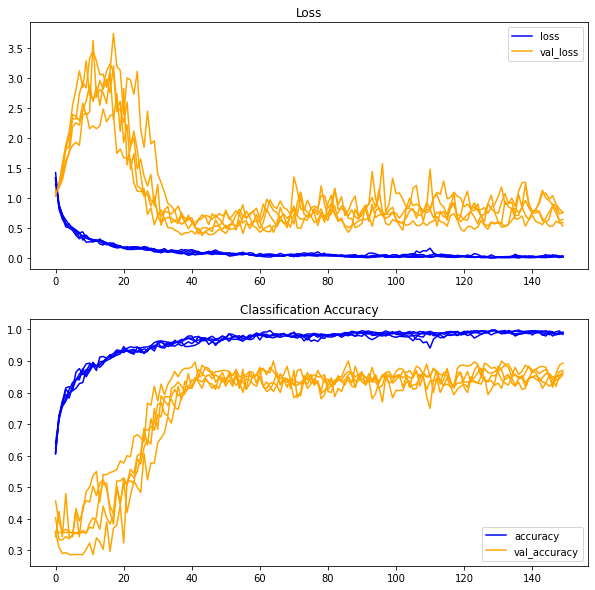

Accuracy: mean=86.933 std=1.272, n=5


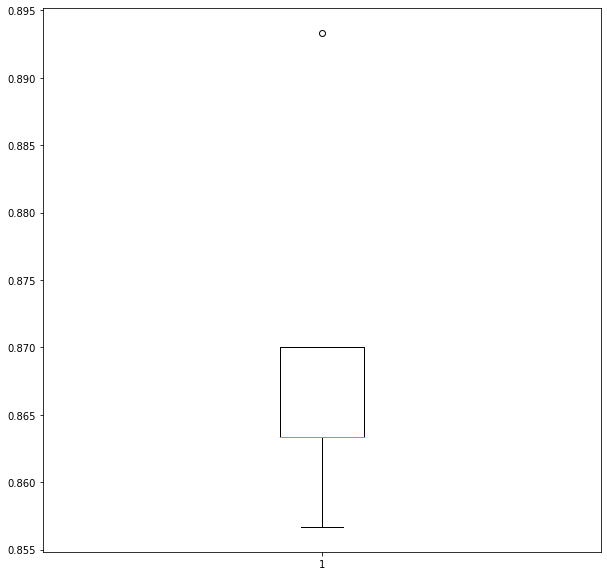

Scores:  [0.8700000047683716, 0.8933333158493042, 0.8633333444595337, 0.8633333444595337, 0.8566666841506958]


In [36]:
# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
 
print("Scores: ",scores)

# **Ensamble of networks**

In [37]:
# make predictions
yhats = [model.predict(x_test) for model in models]
yhats = np.array(yhats)
# sum across ensembles
summed = np.sum(yhats, axis=0)/len(models)
# argmax across classes
outcomes = np.argmax(summed, axis=1)

# true outcomes
outcomes_true = np.argmax(y_test,axis = 1)


score = (len(outcomes) - np.count_nonzero(outcomes-outcomes_true))/len(outcomes)

print("Ensamble test accuracy: ",score*100.,"%")


Ensamble test accuracy:  90.10000000000001 %


In [38]:
# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix


#confusion matrix
cm = confusion_matrix(outcomes_true,outcomes)
print(cm)



[[899  48  53]
 [ 33 957  10]
 [125  28 847]]


# **Plot images**

In [39]:
def plot_images2(y_pred, y_pred_prob):
# Names of predicted classes (randomly chosen images)

  import random


  class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

  #y_pred = model2.predict_classes(x_test)
  #y_pred_prob = model2.predict(x_test)

  grid_w = 10
  grid_h = 10

  fig = plt.figure(figsize=(20, 40))
  for i in range(0,grid_w*grid_h):
    i_pos = 2*(int(i/grid_w))*grid_w+ i%grid_w + 1
    #print(i_pos)
    plt.subplot(2*grid_h, grid_w, i_pos)
    i_img = random.randint(0,len(xx_test))
    plt.imshow(xx_test[i_img])
    #plt.bar([0,1,2,3,4,5,6,7,8,9],y_test[i_img])
    plt.axis('off')
    if yy_test[i_img] == y_pred[i_img]:
      plt.text(0, -2, class_names[int(yy_test[i_img])], color='green', fontsize=12)
    else:
      plt.text(0, -2, class_names[int(yy_test[i_img])]+" "+class_names[y_pred[i_img]], color='red', fontsize=12)  
    plt.subplot(2*grid_h, grid_w, i_pos + grid_w)
    xbar = np.linspace(1, N_CLASSES, num=N_CLASSES)
    plt.bar(xbar,y_pred_prob[i_img])
    plt.axis('off')

  plt.show()


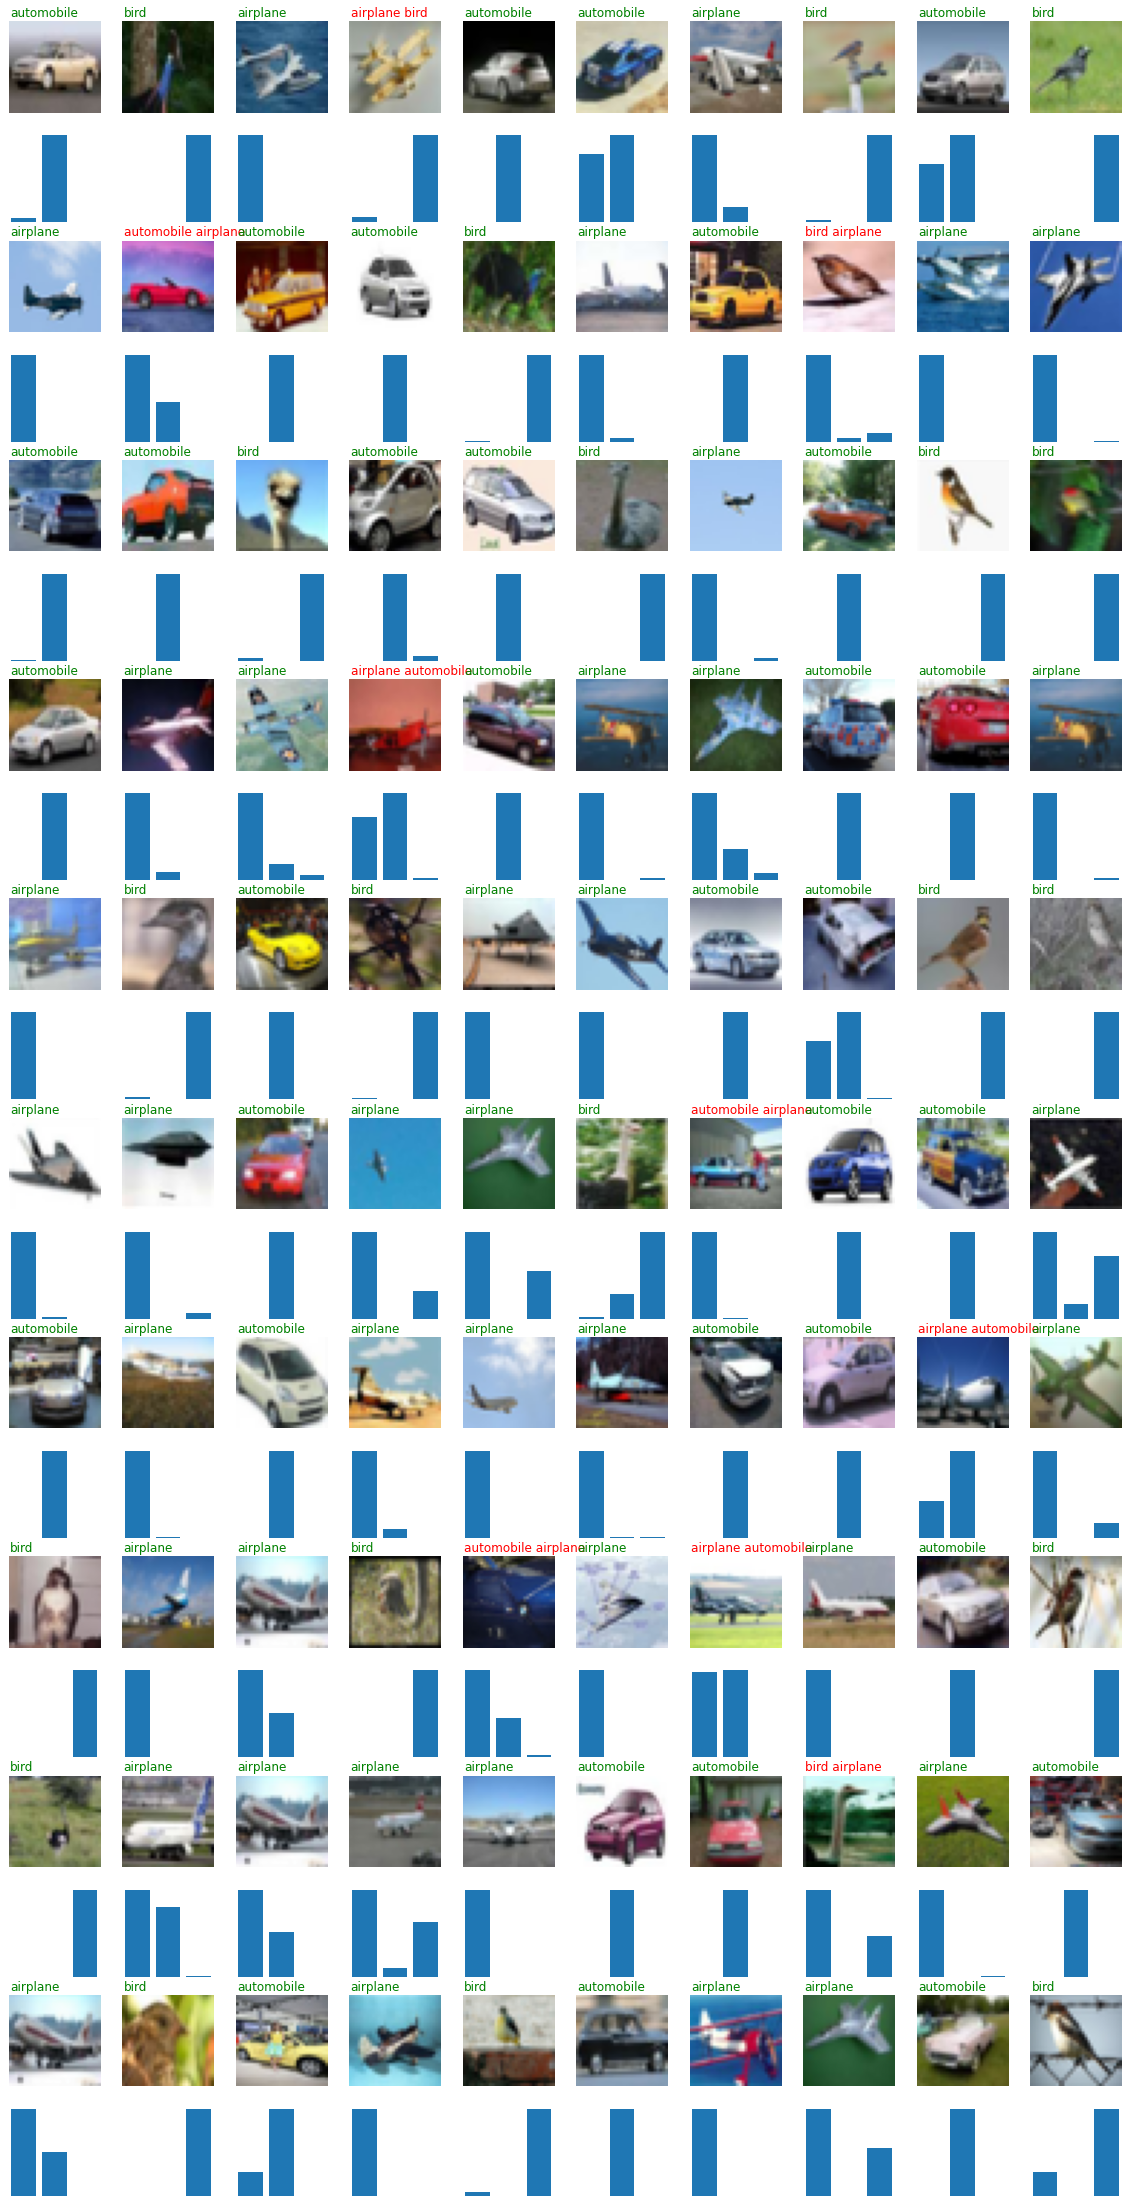

In [40]:
plot_images2(outcomes,summed)

## Visualizing the Optimization History

In [41]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

## Visualizing High-dimensional Parameter Relationships

In [42]:
from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study)

## Visualizing Parameter Relationships

In [43]:
from optuna.visualization import plot_contour

plot_contour(study)

## Visualizing Individual Parameters

In [44]:
from optuna.visualization import plot_slice

plot_slice(study)

## Visualizing Parameter Importances

In [45]:
from optuna.visualization import plot_param_importances

plot_param_importances(study)